In [12]:
import os
import seaborn as sns
import time
import torch
from torch import nn, optim
from torch import tensor
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

In [14]:
class FaceDataset(Dataset):
    def __init__(self, path):
        data = torch.tensor(pd.read_csv(path, header=None).values)
        y, X = data[:,0], data[:,1:]
        y = y.squeeze()
        
        self.X = X.reshape(-1, 1, 48, 48).float()
        self.y = y.long()
        self.scaler = nn.Upsample(size=160, mode='bilinear', align_corners=True)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        X = self.scaler(self.X[i].unsqueeze(0)).squeeze(0)    
        X = torch.cat((X, X, X))
        return X, self.y[i]

In [19]:
train_data = FaceDataset('train.csv')
test_data = FaceDataset('public_test.csv')
private_data = FaceDataset('private.csv')

In [20]:
from facenet_pytorch import MTCNN, InceptionResnetV1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = InceptionResnetV1(classify=True, pretrained='vggface2', num_classes=7)
resnet = resnet.to(device)

In [29]:
freq = np.bincount(train_data.y)
inv_freq = train_data.y.shape[0] / freq
inv_freq = 7 * inv_freq / inv_freq.sum()


loss_function = nn.CrossEntropyLoss(weight=torch.tensor(inv_freq).float().cuda())

optimizer = optim.Adam(resnet.parameters(), lr=1e-5)
total_loss = 0
loader = torch.utils.data.DataLoader(train_data, 64, shuffle=True, num_workers=8)

for epoch in range(10):
    for i, data in enumerate(loader, 0):
        images, classes = data
        images, classes = images.to(device).float(), classes.to(device).long()
        #images, classes = images.float(), classes.long()
        output = resnet(images)
        
        loss = loss_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        total_loss += loss.item() 
        
        if i % 10 == 9:
            print("After epoch {}, mini-batch {}, loss: {}".format(epoch + 1, i + 1, total_loss))
            total_loss = 0
            
    correct = 0
    total = 0
    total_loss = 0

After epoch 1, mini-batch 10, loss: 13.60009878873825
After epoch 1, mini-batch 20, loss: 13.271961450576782
After epoch 1, mini-batch 30, loss: 14.500711977481842
After epoch 1, mini-batch 40, loss: 14.883895754814148
After epoch 1, mini-batch 50, loss: 11.96181458234787
After epoch 1, mini-batch 60, loss: 12.799401342868805
After epoch 1, mini-batch 70, loss: 12.117967009544373
After epoch 1, mini-batch 80, loss: 14.22002387046814
After epoch 1, mini-batch 90, loss: 14.112419724464417
After epoch 1, mini-batch 100, loss: 13.634794473648071
After epoch 2, mini-batch 10, loss: 6.945316880941391
After epoch 2, mini-batch 20, loss: 6.385809749364853
After epoch 2, mini-batch 30, loss: 7.2076307237148285
After epoch 2, mini-batch 40, loss: 6.527051091194153
After epoch 2, mini-batch 50, loss: 5.65737572312355
After epoch 2, mini-batch 60, loss: 6.225296914577484
After epoch 2, mini-batch 70, loss: 6.073084592819214
After epoch 2, mini-batch 80, loss: 6.837082028388977
After epoch 2, mini-

In [30]:

with torch.no_grad():
    actual, prediction = [], []
    test_loader = torch.utils.data.DataLoader(private_data, 1000, shuffle=False, num_workers=8)

    for i, data in enumerate(test_loader):
        images, features = data
        images, features = images.to(device).float(), features.to(device).float()

        output = resnet(images)
        #output = model(activations)
        output = torch.argmax(output, dim=1)
        #if not result:
        #    result = output.cpu()
        #else:
        #result = torch.cat((result, output.cpu()))
        actual.extend(features.cpu().tolist())
        prediction.extend(output.cpu().tolist())
        if i % 10 == 0:
            print(i)
    
    print(confusion_matrix(actual, prediction))
    print(accuracy_score(actual, prediction))
    print(f1_score(actual, prediction, average='macro'))

0
10
[[   0 2696  268 2581 4736 3272 2177 3427]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]
0.0
0.0


In [24]:
with torch.no_grad():
    actual, prediction = [], []
    test_loader = torch.utils.data.DataLoader(test_data, 1000, shuffle=False, num_workers=8)

    for i, data in enumerate(test_loader):
        images, features = data
        images, features = images.to(device).float(), features.to(device).float()

        output = resnet(images)
        #output = model(activations)
        output = torch.argmax(output, dim=1)
        #if not result:
        #    result = output.cpu()
        #else:
        #result = torch.cat((result, output.cpu()))
        actual.extend(features.cpu().tolist())
        prediction.extend(output.cpu().tolist())
        if i % 10 == 0:
            print(i)
    
    print(confusion_matrix(actual, prediction))
    print(accuracy_score(actual, prediction))
    print(f1_score(actual, prediction, average='macro'))

0
[[ 502   17  100   36  115   26   96]
 [  18   52    7    2   16    1    2]
 [ 115   15  406   35  175  101   72]
 [  38    2   37 1386   41   34   84]
 [ 103    6  168   51  595   17  157]
 [  18    2   62   43   21  547   24]
 [  75    2   69   80  176   27  685]]
0.6460752438457965
0.6152528320291809


In [31]:
output_csv = open('output_csv', 'w')
output_csv.write("Id,Prediction\n")
for i, elem in enumerate(prediction):
    output_csv.write('{},{}\n'.format(i + 1, elem))
output_csv.close()

In [11]:
print(len(test_dataset))

19157


In [94]:

class MinFaceDataset(Dataset):
    def __init__(self, path, over_sample=False):
        y, X = np.split(np.genfromtxt(path, delimiter=','), [1], axis=-1)
        y = y.squeeze()
        if over_sample:
            X, y = RandomOverSampler().fit_resample(X, y)
        X = X.reshape(-1, 1, 48, 48)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train = MinFaceDataset('/home/cse/dual/cs5180404/col774/train.csv')
orig = MinFaceDataset('/home/cse/dual/cs5180404/col774/orig_train.csv')
pubtest = MinFaceDataset('/home/cse/dual/cs5180404/col774/public_test.csv')
pvttest = MinFaceDataset('/home/cse/dual/cs5180404/col774/private.csv')

In [114]:
matrix = np.zeros((4, 4))
l = [train, orig, pubtest, pvttest]
for i, a in enumerate(l):
    for j, b in enumerate(l):
        if i > j:
            combined = torch.cat((a.X.squeeze(1).view(a.X.shape[0], -1), b.X.squeeze(1).view(b.X.shape[0], -1)))
            print(combined.shape)
            unique = torch.unique(combined, dim=0)
            print(a.X.shape[0], b.X.shape[0], unique.shape[0])
            intersection = a.X.shape[0] + b.X.shape[0] - unique.shape[0]
            matrix[i][j] = intersection
#c = torch.cat((c1.X.reshape((6459, 2304)), c2.X.reshape((19157, 2304))))
#print(c.shape)
#unique, counts = torch.unique(c2.X.reshape((19157, 2304)), dim=0, return_counts=True)
#print(unique.shape, counts)
#unique, counts = torch.unique(c1.X.reshape((6459, 2304)), dim=0, return_counts=True)
#print(unique.shape, counts)

torch.Size([48085, 2304])
28709 19376 46265
torch.Size([25835, 2304])
6459 19376 24832
torch.Size([35168, 2304])
6459 28709 33868
torch.Size([38533, 2304])
19157 19376 25044
torch.Size([47866, 2304])
19157 28709 33889
torch.Size([25616, 2304])
19157 6459 12743


In [127]:
print(train.X.shape, pvttest.X.shape)
upvttest = torch.unique(pvttest.X, dim=0)
utrain = torch.unique(train.X, dim=0)

combined = torch.cat((upvttest, utrain), dim=0)
print(upvttest.shape)
print(utrain.shape)
print(combined.shape)
print(torch.unique(combined, dim=0).shape)

torch.Size([19376, 1, 48, 48]) torch.Size([19157, 1, 48, 48])
torch.Size([6416, 1, 48, 48])
torch.Size([18792, 1, 48, 48])
torch.Size([25208, 1, 48, 48])
torch.Size([25044, 1, 48, 48])


In [109]:
a = torch.zeros((2, 2, 3, 4))
print(a.shape)
print(a.view(2, -1).shape)

torch.Size([2, 2, 3, 4])
torch.Size([2, 24])


torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])
torch.Size([160, 160])


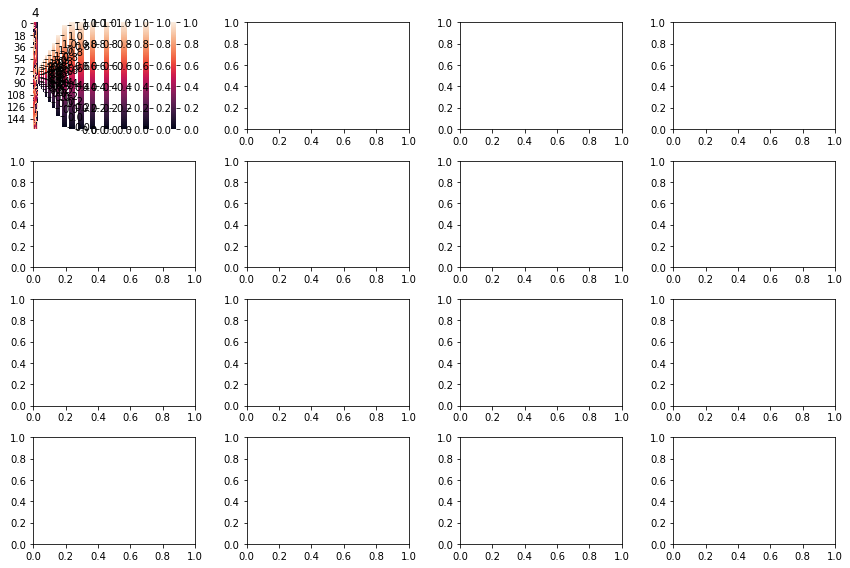

In [111]:
fig, ax = plt.subplots(4, 4, figsize=(12,8))
start = 64
for i in range(start, start + 16):
    print(train_dataset.__getitem__(i)[0].squeeze(0)[0].shape)
    sns.heatmap(train_dataset.__getitem__(i)[0].squeeze(0)[0], ax=ax[j//4][j%4])
    ax[j//4][j%4].set_title(str(orig_dataset.__getitem__(i)[1].item()))
plt.tight_layout()